This notebook implements many differents solutions for the PLN PCA model. This is more a test of the  differents methods since we are building ourselves the data, and we know the true parameter Sigma and beta. This is just to check the method. 

In [1]:
%load_ext autoreload

%autoreload 2

In [177]:
import math
import time 
from fastPLNmodels.utils import init_C, init_M, RMSE,Poisson_reg, sample_PLN, build_block_Sigma, C_from_Sigma, MSE
from fastPLNmodels.models import fastPLN, IMPS_PLN, show
import matplotlib.pyplot as plt

import numpy as np
import torch
import threading
import seaborn as sns
from tqdm import tqdm
import scipy.linalg as SLA 
from scipy.linalg import toeplitz 
from sklearn.linear_model import LinearRegression
torch.set_default_dtype(torch.float64)

In [2]:
#get the device
if torch.cuda.is_available(): 
    device = torch.device('cuda') 
else : 
    device = torch.device('cpu')
print('device : ', device)

NameError: name 'torch' is not defined

In [108]:
def launch_dimensions(dict_dimensions,N_iter, lr):
    '''
    launch some optimizers to compare them after. 
    args : 
         dict_optimizer : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         lr : float. the learning rate of each optimizer.
    '''
    ts = list()
    models = list()
    for name, dim in dict_dimensions.items(): 
        model = fastPLNPCA()
        t = threading.Thread(target =model.fit,
              args = [data, N_iter  ,dim,               'PCA',              0 ,           torch.optim.Rprop,      1,     False ])
                     # data, N_iter, q, loss_choice = 'PCA', tolerance = 0, optimizer = torch.optim.Rprop, lr = 1,verbose = False
        #t = threading.Thread(target =model.VEM_both_closed,
        #      args = [data, N_iter           ,Nb_each_iter      , lr,  0.01 , False] )
        t.start()
        ts.append(t)
        models.append(model)
    for t in ts : 
        t.join()
        
    return dict(zip(dict_dimensions.keys(), models))

def launch_optimizers(dict_optimizers,N_iter, lr):
    '''
    launch some optimizers to compare them after. 
    args : 
         dict_optimizer : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         lr : float. the learning rate of each optimizer.
    '''
    ts = list()
    models = list()
    Nb_each_iter = 20 
    for name, optimizer in dict_optimizers.items(): 
        model = fastPLNPCA()
        t = threading.Thread(target =model.fit,
              args = [data, N_iter  ,p//2,               'PCA',              0 ,           optimizer,      1,     False ])
        t.start()
        ts.append(t)
        models.append(model)
    for t in ts : 
        t.join()
        
    return dict(zip(dict_optimizers.keys(), models))




Max ELBO 1060538.9554203737


<ipython-input-108-eb40bc607e80>:76: RuntimeWarning: divide by zero encountered in log
  ax[0].plot(abscisse, np.log(-np.array(model.ELBO_list)+max_), label = 'ELBO')


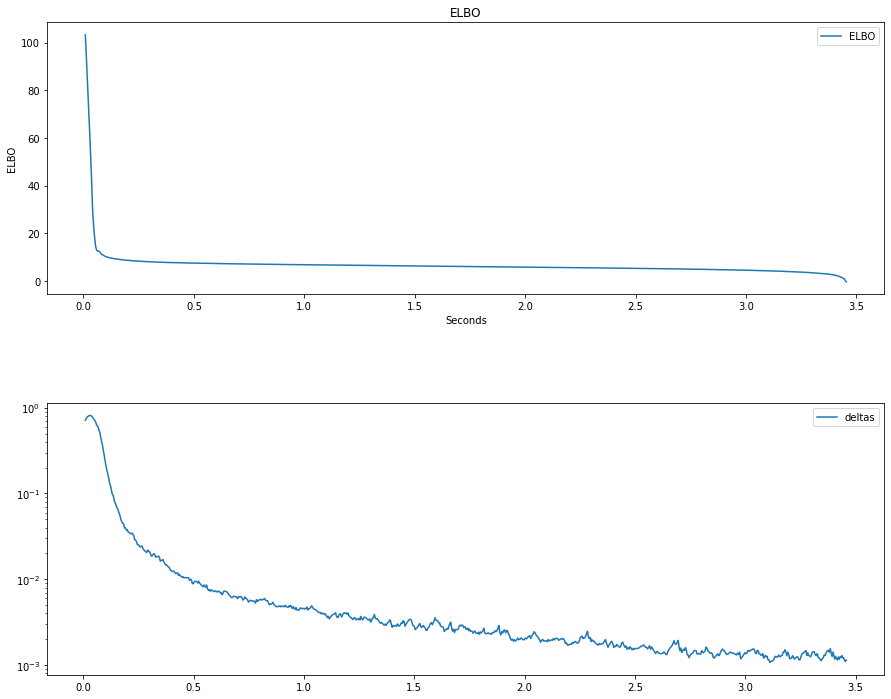

NameError: name 'dict_models' is not defined

In [109]:
compare_models(model)

In [7]:
def constrain(Sigma,q): 
    w,v = SLA.eigh(Sigma)
    w = torch.from_numpy(w)
    v = torch.from_numpy(v)
    w_bis = torch.clone(w)
    p = Sigma.shape[0]
    w_bis[:p-q] = 0 
    constrained = v@torch.diag(w_bis)@v.T
    return constrained

In [32]:
fast= fastPLN()
fast.fit(Y_sampled, O, covariates, 200)

NameError: name 'RMSE' is not defined

In [6]:
target = Z_sampled+ torch.mm(covariates,true_beta)
clf = LinearRegression()
clf.fit(covariates,target)
beta_dream = torch.from_numpy(clf.coef_.T)
MLE_beta = torch.mean((beta_dream-true_beta)**2)
print('MSE beta in the latent layer:', MLE_beta)

NameError: name 'Z_sampled' is not defined

MLE :


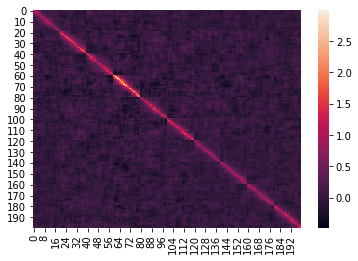

true Sigma
Best MSE we can have (in our dream):  tensor(0.0098)


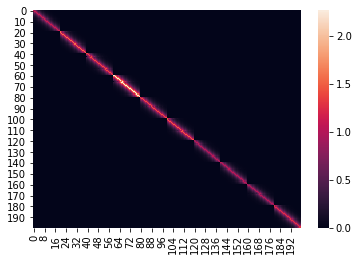

In [75]:
## Here we plot the MLE for Z the latent variables. They are unknown in practice
## this is just to see the difference between our result and the best result possible 
mu_MLE = torch.mean(Z_sampled, dim = 0)
m = mu_MLE.shape[0]
Sigma_MLE = 1/Z_sampled.shape[0]*((Z_sampled-mu_MLE).T)@(Z_sampled-mu_MLE)
print('MLE :')
sns.heatmap(Sigma_MLE.to(torch.device('cpu')))
plt.show()
print('true Sigma')
sns.heatmap(true_Sigma.to(torch.device('cpu')))
MLE_Sigma = torch.mean((Sigma_MLE.to(device)-true_Sigma)**2)
print('Best MSE we can have (in our dream): ', MLE_Sigma)

In [156]:
model.ELBO_list[-1]

1531805.4212219277

In [173]:
model.M

tensor([[-0.0387, -0.4096, -1.1044,  ..., -0.3088,  1.1447, -0.2328],
        [-0.2315, -0.5180,  0.3137,  ..., -1.0745,  0.8421, -0.2638],
        [ 0.8145,  0.2577, -1.2226,  ..., -1.3402,  1.0904,  0.5131],
        ...,
        [-0.8622,  1.2654, -0.2864,  ..., -1.4850,  1.0835, -0.8273],
        [ 1.0426,  1.3747,  0.2705,  ...,  0.9838,  1.2087, -0.9742],
        [ 0.1499,  1.5924, -0.4115,  ...,  0.5405,  1.0019,  0.9416]],
       requires_grad=True)

In [209]:
IMPS = IMPS_PLN(q)
IMPS.fit(Y_sampled, O, covariates, 300, 0.005, nb_plateau = 25)

 24%|██▎       | 71/300 [02:19<07:30,  1.97s/it]

Algorithm stopped after  71  iterations


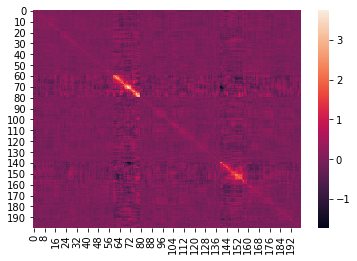

In [210]:
IMPS.show_Sigma()

In [199]:
model= fastPLNPCA()
%time model.fit(data, q,2000, verbose = True, good_init = True, lr =  0.1,tolerance = 0)

nb iteration to find the mode:  166
Iteration number:  0
-------UPDATE-------
Delta :  0.23687743019477656
Iteration number:  100
-------UPDATE-------
Delta :  0.0024020195139897406
Iteration number:  200
-------UPDATE-------
Delta :  0.0018660099007372112
Iteration number:  300
-------UPDATE-------
Delta :  0.0012790123988778404
Iteration number:  400
-------UPDATE-------
Delta :  0.0008353852166241872
Iteration number:  500
-------UPDATE-------
Delta :  0.0005737770274947542
Iteration number:  600
-------UPDATE-------
Delta :  0.0004593385325929035
Iteration number:  700
-------UPDATE-------
Delta :  0.0003887594834193996
Iteration number:  800
-------UPDATE-------
Delta :  0.00027979419384272257
Iteration number:  900
-------UPDATE-------
Delta :  0.00023541269718666138
Iteration number:  1000
-------UPDATE-------
Delta :  0.00015562710468584098
Iteration number:  1100
-------UPDATE-------
Delta :  0.0001544181440792465
Iteration number:  1200
-------UPDATE-------
Delta :  0.0001031

In [111]:
x = torch.ones((100, 4))/2
#print(x)

torch.distributions.binomial.Binomial(probs = x).sample()

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 1., 1., 1.],
        [0., 0., 0., 1.],
        [1., 0., 1., 1.],
        [1., 1., 1., 0.],
        [0., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 1., 0.],
        [0., 1., 1., 0.],
        [1., 1., 0., 1.],
        [1., 1., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 1.],
        [0., 0., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.],
        [0.,

In [207]:
d = 1 # nb of cavariates
n = 200; p = 200
q = 15

In [208]:
#torch.manual_seed(0)
#true_Sigma = torch.from_numpy(toeplitz(0.6**np.arange(p)))
true_Sigma = 1/3*torch.from_numpy(build_block_Sigma(p,20))#.to(device)
true_C = C_from_Sigma(torch.from_numpy(SLA.sqrtm(true_Sigma)), q)
true_beta = torch.randn(d, p).to(device)

covariates = torch.randn((n,d))
#covariates[:, 0] = -1
O =  0+torch.zeros((n,p))

Y_sampled, Z_sampled,_  = sample_PLN(true_Sigma.to(device),true_beta.to(device), O, covariates, ZI = False)
Y_sampled = torch.from_numpy(Y_sampled)

#covariates-=torch.mean(covariates, axis = 0)
data = [Y_sampled.double(), O, covariates]
#compute_SNR(covariates,true_beta, Y_sampled)  

Max ELBO 789942.0988218327


<ipython-input-148-a1bcaab2354d>:183: RuntimeWarning: divide by zero encountered in log
  ax[0].plot(abscisse, np.log(-np.array(self.ELBO_list)+max_), label = 'ELBO')


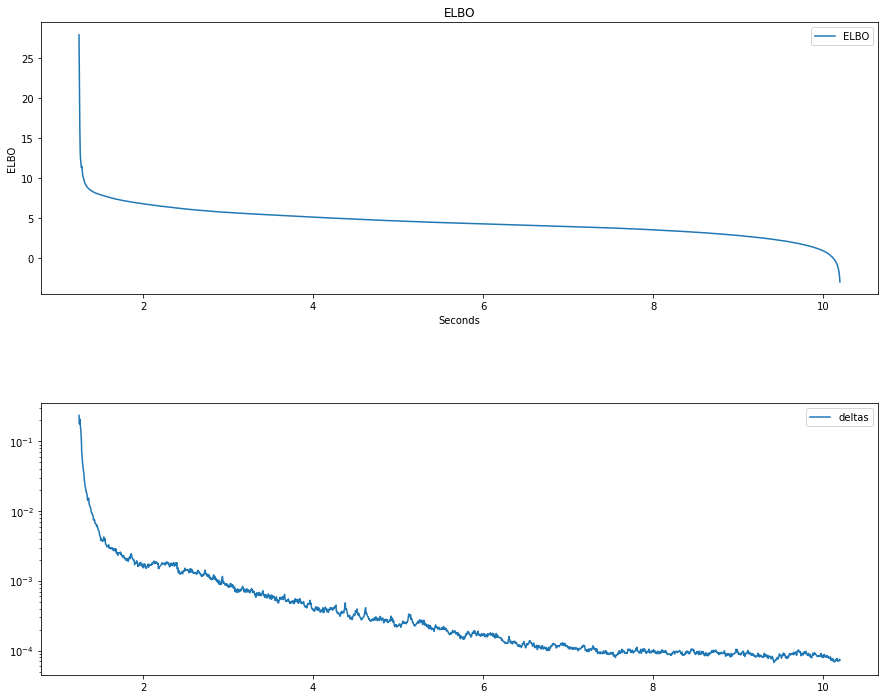

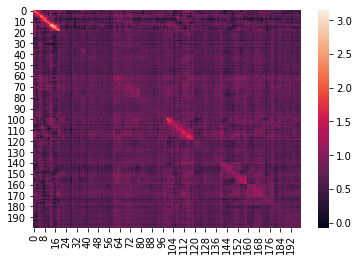

In [203]:
model.show()

<AxesSubplot:>

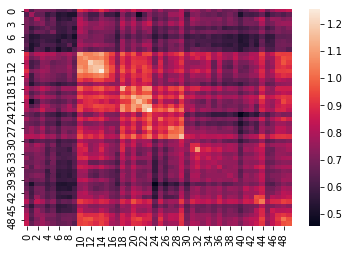

In [211]:
n_a = 50
n_b = 100
sns.heatmap(model.get_Sigma()[n_a:n_b,n_a:n_b].detach())

<AxesSubplot:>

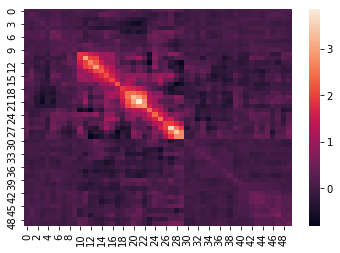

In [212]:
sns.heatmap((IMPS.C@(IMPS.C.T)).detach()[n_a:n_b, n_a:n_b])

<AxesSubplot:>

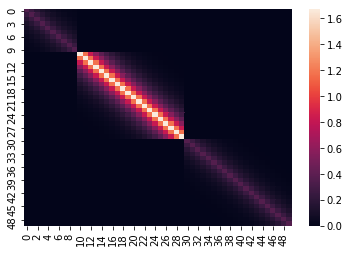

In [213]:
sns.heatmap(true_Sigma[n_a:n_b,n_a:n_b].detach())

In [16]:
def compute_SNR(covariates, beta, Y): 
    eps = Y_sampled-torch.exp(covariates@beta)  
    num = torch.mean(torch.norm(torch.exp(covariates@beta), dim = 1)**2)
    denom = torch.mean(torch.norm(eps, dim = 1)**2)
    SNR = num/denom
    return SNR
compute_SNR(covariates,true_beta, Y_sampled)  

tensor(0.9545)

max : 2865111.2953750743


<ipython-input-953-68ce135c535a>:96: RuntimeWarning: divide by zero encountered in log
  ax[2].plot(abscisse[-int(length*percentage_kept):], np.log(-np.array(model.ELBO_list[-int(length*percentage_kept):])+max_), label = name )


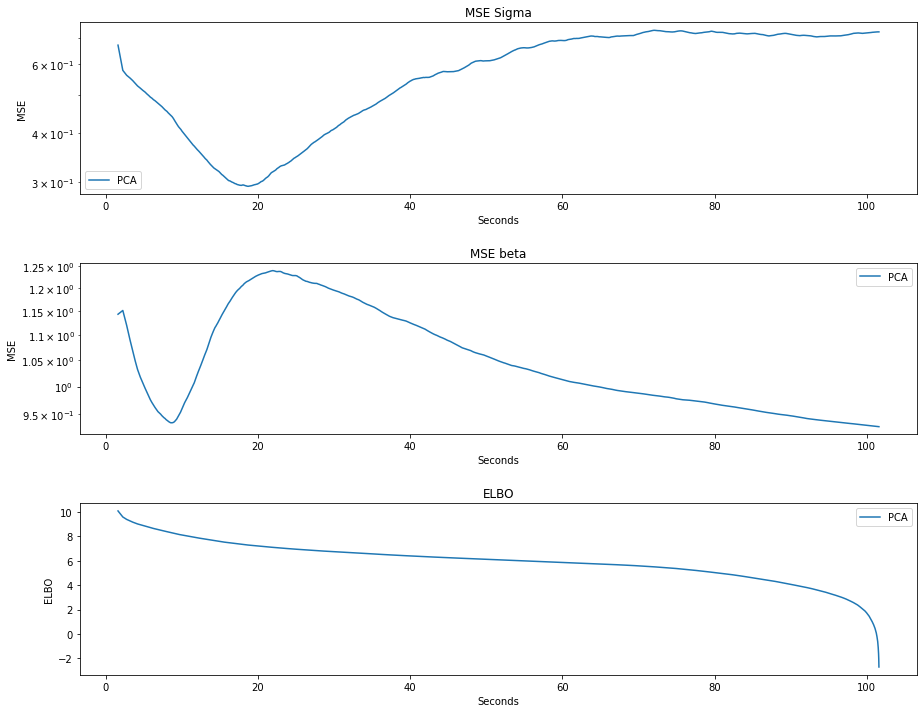

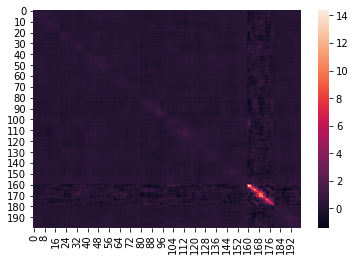

In [1206]:
compare_models({'PCA': model_VEM}, '')

In [22]:
from fastPLNmodels.models import fastPLNPCA, fastPLN, IMPS_PLN
from fastPLNmodels.utils import build_block_Sigma, sample_PLN, C_from_Sigma, MSE
import scipy.linalg as SLA
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cpu')

In [45]:
d = 1 # nb of cavariates
n = 1000; p = 100
q = 15

In [46]:
#torch.manual_seed(0)
#true_Sigma = torch.from_numpy(toeplitz(0.6**np.arange(p)))
true_Sigma = 1/3*torch.from_numpy(build_block_Sigma(p,20))#.to(device)
true_C = C_from_Sigma(torch.from_numpy(SLA.sqrtm(true_Sigma)), q)
true_beta = torch.randn(d, p).to(device)

covariates = torch.randn((n,d))
#covariates[:, 0] = -1
O =  0+torch.zeros((n,p))

Y_sampled, Z_sampled,_  = sample_PLN(true_Sigma.to(device),true_beta.to(device), O, covariates, ZI = False)
Y_sampled = torch.from_numpy(Y_sampled)

#covariates-=torch.mean(covariates, axis = 0)
data = [Y_sampled.double(), O, covariates]
#compute_SNR(covariates,true_beta, Y_sampled) 

In [6]:
model = fastPLNPCA()
%time model.fit(Y_sampled, O, covariates, q, good_init = True)

nb iteration to find the mode:  222
Tolerance 0.0002 reached in 584 iterations
CPU times: user 1min 29s, sys: 3.4 s, total: 1min 33s
Wall time: 5.84 s


<AxesSubplot:>

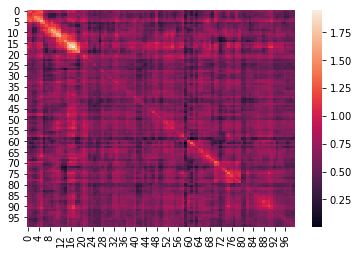

In [42]:
n_a = 100
n_b = 200
sns.heatmap(model.get_Sigma().detach()[n_a:n_b, n_a:n_b])

<AxesSubplot:>

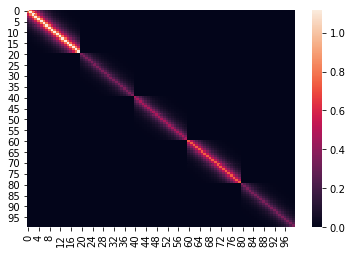

In [43]:
sns.heatmap(true_Sigma[n_a:n_b, n_a:n_b])

<AxesSubplot:>

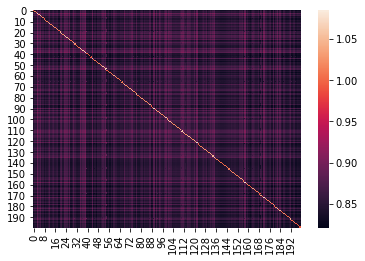

In [140]:
n_a = 0
n_b = 200
sns.heatmap(fast.Sigma.detach()[n_a:n_b, n_a:n_b])

<AxesSubplot:>

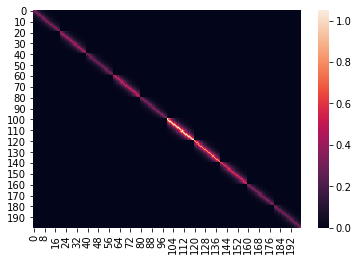

In [141]:
sns.heatmap(true_Sigma[n_a:n_b, n_a:n_b])

In [47]:
imps = IMPS_PLN()
imps.fit(Y_sampled,O,covariates, acc = 0.005, q = q, batch_size = 50)

Intialization ...


  0%|          | 0/200 [00:00<?, ?it/s]

Initalization done


 20%|█▉        | 39/200 [02:55<12:04,  4.50s/it]

Algorithm stopped after  39  iterations


No handles with labels found to put in legend.
No handles with labels found to put in legend.


max likelihood : -170.8840885009967


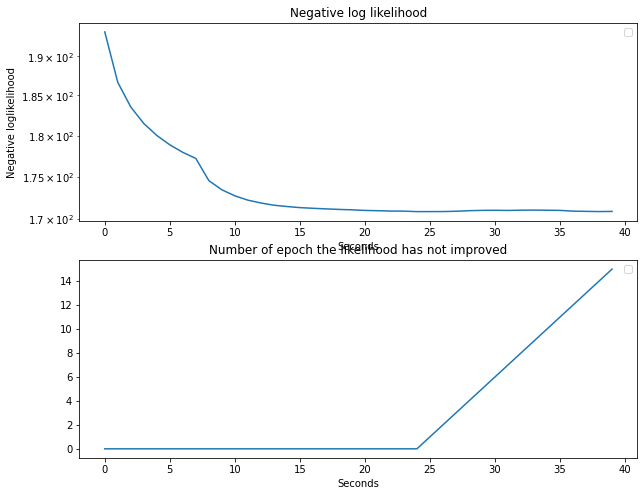

In [48]:
imps.show()

In [49]:
print(MSE(imps.get_Sigma()-true_Sigma))
print(MSE(imps.beta-true_beta))


tensor(0.0102)
tensor(0.0049)


In [50]:
imps_noVR = IMPS_PLN()
imps_noVR.fit(Y_sampled,O,covariates, acc = 0.005, q = q, VR = None, batch_size = 50)

Intialization ...


  0%|          | 0/200 [00:00<?, ?it/s]

Initalization done


 26%|██▌       | 52/200 [03:48<10:49,  4.39s/it]

Algorithm stopped after  52  iterations


No handles with labels found to put in legend.
No handles with labels found to put in legend.


max likelihood : -172.85671272838135


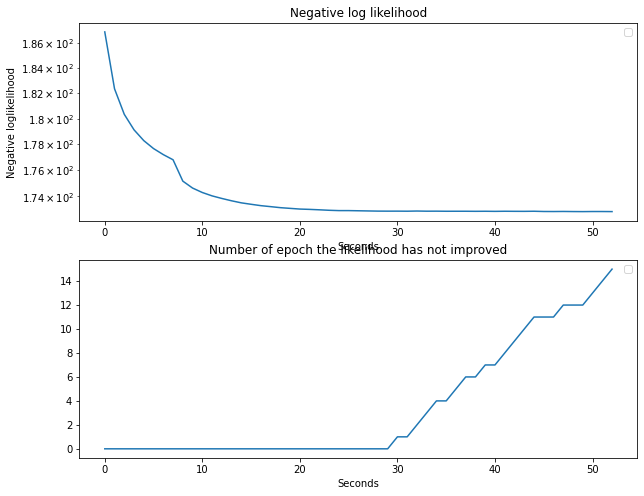

In [51]:
imps_noVR.show()

In [40]:
print(MSE(imps_noVR.get_Sigma()-true_Sigma))
print(MSE(imps_noVR.beta-true_beta))

tensor(0.1609)
tensor(0.0336)


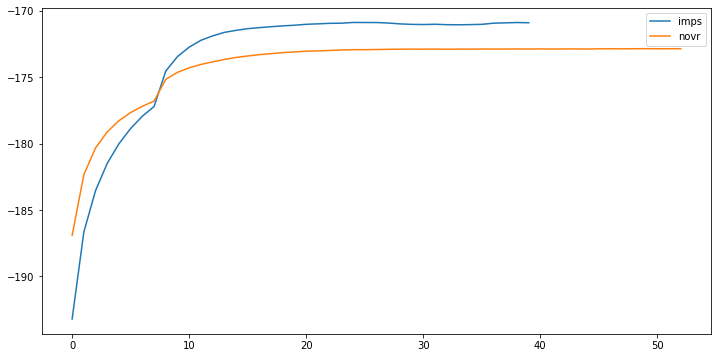

In [52]:
def compare_imps(dict_models): 
    fig, axes = plt.subplots(1,1, figsize = (12,6))
    for name, model in dict_models.items(): 
        axes.plot(np.arange(len(model.log_likelihood_list)), model.log_likelihood_list, label = name)
    axes.legend()

compare_imps({'imps': imps, 'novr': imps_noVR})

In [54]:
imps_ada = IMPS_PLN()
imps_ada.fit(Y_sampled,O,covariates, acc = 0.005, q = q, batch_size = 50, class_optimizer = torch.optim.Adagrad)

Intialization ...


  0%|          | 0/200 [00:00<?, ?it/s]

Initalization done


100%|██████████| 200/200 [12:36<00:00,  3.78s/it]


In [58]:
imps_noVR_ada = IMPS_PLN()
imps_noVR_ada.fit(Y_sampled,O,covariates, acc = 0.005, q = q, VR = None, batch_size = 50, class_optimizer = torch.optim.Adagrad)

Intialization ...


  0%|          | 0/200 [00:00<?, ?it/s]

Initalization done


100%|██████████| 200/200 [13:16<00:00,  3.98s/it]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


max likelihood : -171.8333600868611


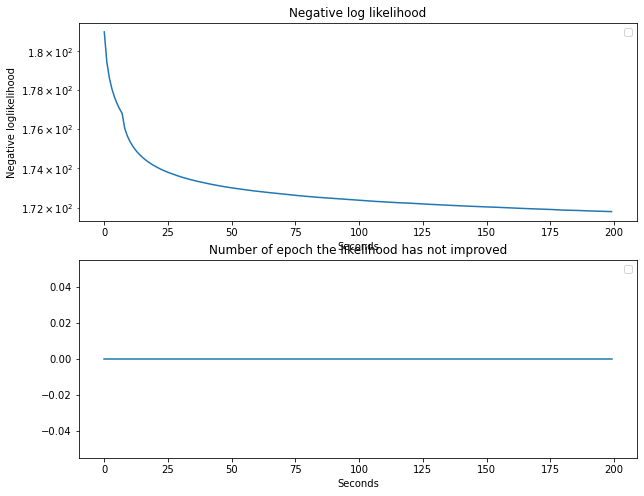

In [60]:
imps_noVR_ada.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


max likelihood : -170.50007689349235


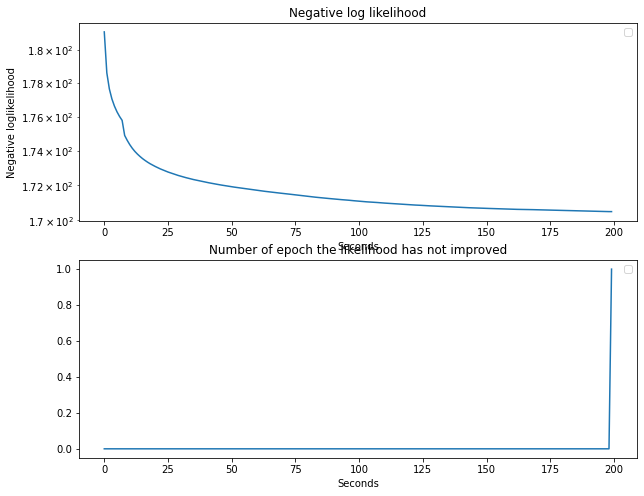

In [57]:
imps_ada.show()

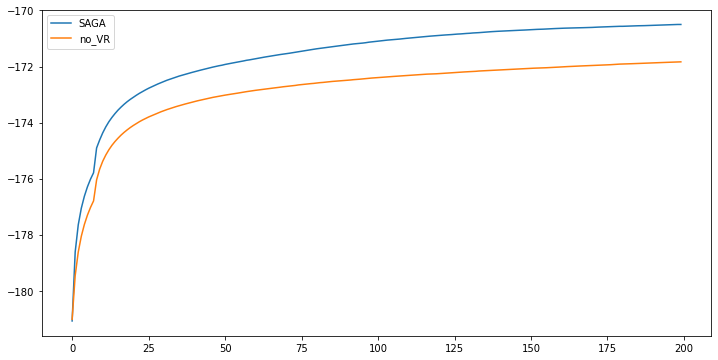

In [62]:
compare_imps({'SAGA': imps_ada, 'no_VR': imps_noVR_ada})

In [ ]:
def loss(x): 
    return torch.mean(x**2)

n = 1000
X = torch.randn(1000)

def get_batches(x):
    indices = np.arange(0, X.shape[0])
    np.random.shuffle(indices)
    for i in range()

for j in range()